In [1]:
import bbmaster as mst
import numpy as np
import matplotlib.pyplot as plt
import pymaster as nmt
import healpy as hp

### 1. Setup
- Read mask.
- Define bandpower bins
- Initialize bandpower window function calculator

In [2]:
# Read mask
nside = 64
msk = hp.read_map("../SensitivityCheck/data/mask_apodized.fits")
# Generate NaMaster bins
b = nmt.NmtBin(nside, nlb=10)
# Bbl calculator
# Dictionary defining method to generate delta sims (not many options yet!)
dsim = {"stats": "Gaussian"}
# Dictionary defining method to filter (just masking for now)
filt = {"mask": msk}
bc = mst.DeltaBbl(nside, dsim, filt, b)

### 2. Compute exact bandpowers
Now let's use NaMaster to compute the exact bandpower windows, and plot them

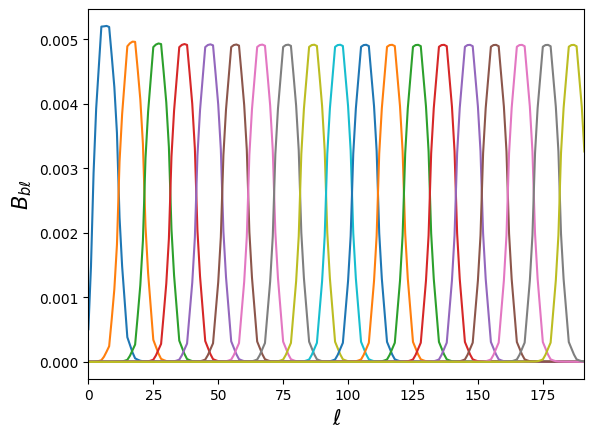

In [3]:
f = nmt.NmtField(hp.ud_grade(msk, nside_out=nside), None, spin=0)
w = nmt.NmtWorkspace()
w.compute_coupling_matrix(f, f, b)
mcm = w.get_coupling_matrix()

bpw_true = np.array([b.bin_cell(m) for m in mcm.T]).T

for bpw in bpw_true:
    plt.plot(bpw)
plt.xlim([0, 3 * nside - 1])
plt.xlabel("$\ell$", fontsize=15)
plt.ylabel("$B_{b\ell}$", fontsize=15);

### 3. Compute bandpower windows through simulations

In [4]:
bpw_num = bc.gen_Bbl_all()

Now compute them using $Z_2$ rather than Gaussian sims

In [5]:
dsim = {"stats": "Z2"}
bc_z2 = mst.DeltaBbl(nside, dsim, filt, b)
bpw_num_z2 = bc_z2.gen_Bbl_all()

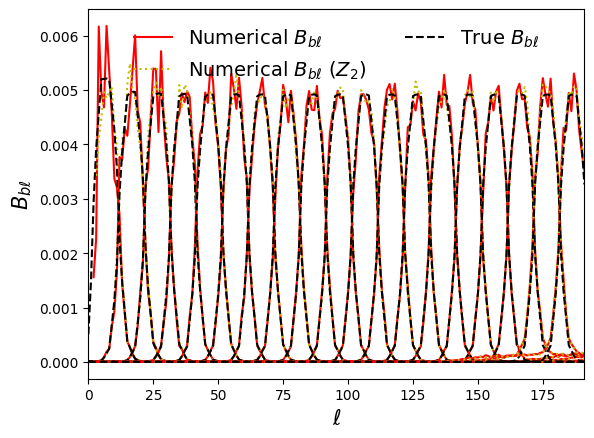

In [7]:
for bpw_t, bpw_n, bpw_z2 in zip(bpw_true, bpw_num, bpw_num_z2):
    plt.plot(bc.get_ells(), bpw_n, "r-")
    plt.plot(bc.get_ells(), bpw_z2, "y:")
    plt.plot(bpw_t, "k--")
plt.plot([-1], [0], "r-", label="Numerical $B_{b\ell}$")
plt.plot([-1], [0], "y:", label="Numerical $B_{b\ell}\,\,(Z_2)$")
plt.plot([-1], [0], "k--", label="True $B_{b\ell}$")
plt.xlim([0, 3 * nside - 1])
plt.xlabel("$\ell$", fontsize=15)
plt.ylabel("$B_{b\ell}$", fontsize=15)
plt.legend(ncol=2, loc="upper center", fontsize=14, frameon=False);

Uuuh, notice the crap in the last few bandpowers? This is all HEALPix rubbish for $\ell>2 N_{\rm side}$, so just a reminder that we need to throw that away!

In [46]:
alm = hp.Alm()
sqrt2 = np.sqrt(2.0)
oosqrt2 = 1 / sqrt2


def get_dmap(ell):
    idx = alm.getidx(3 * nside - 1, ell, np.arange(ell + 1))
    rans = oosqrt2 * (2 * np.random.binomial(1, 0.5, size=2 * (ell + 1)) - 1).reshape(
        [2, ell + 1]
    )
    rans[0, 0] *= sqrt2
    rans[1, 0] = 0
    alms = np.zeros(alm.getsize(3 * nside - 1), dtype="complex128")
    alms[idx] = rans[0] + 1j * rans[1]
    print(hp.alm2cl(alms)[ell])
    return hp.alm2map(alms, nside)

0.9999999999999998
0.9999999999999998
0.9999999999999998


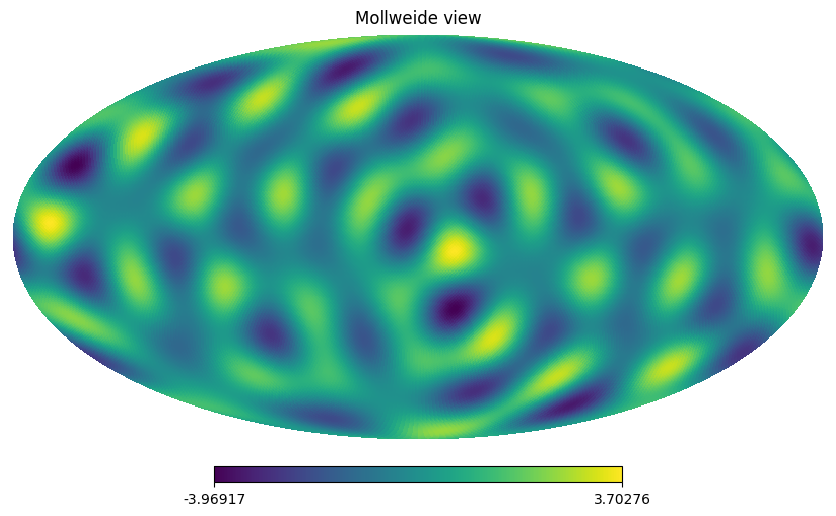

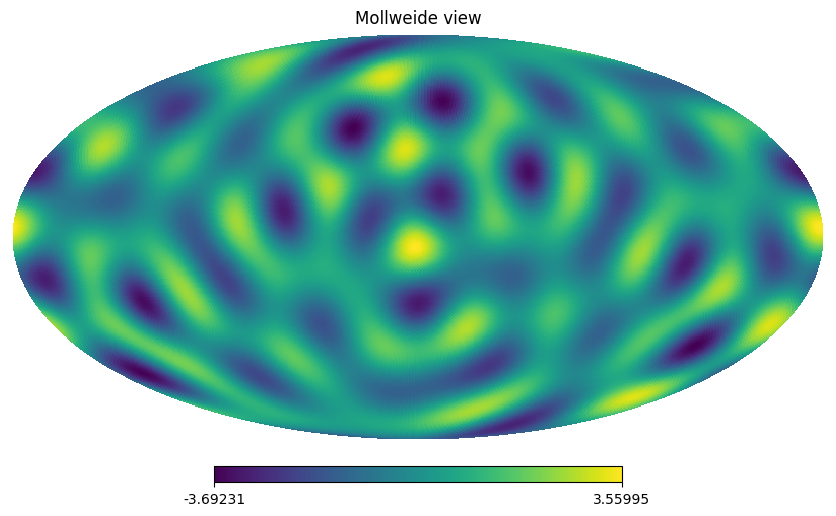

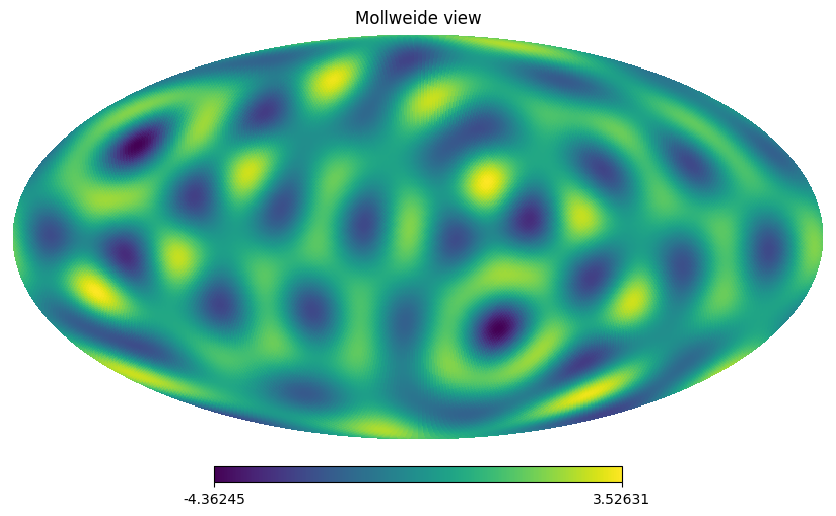

In [48]:
hp.mollview(get_dmap(10))
hp.mollview(get_dmap(10))
hp.mollview(get_dmap(10))

In [43]:
print(hp.alm2cl(alms))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [26]:
np.mean((2 * np.random.binomial(1, 0.5, size=100) - 1) / np.sqrt(2))

-0.04242640687119284

In [32]:
alm = hp.map2alm(np.random.randn(hp.nside2npix(nside)))

In [35]:
alm.dtype

dtype('complex128')